# Denoising Diffusion Probabilistic Models (DDPMs)

## Introduction

Denoising Diffusion Probabilistic Models (DDPM) are deep generative models that are recently getting a lot of attention due to their impressive performances. Brand new models like OpenAI’s DALL-E 2 and Google’s Imagen generators are based on DDPMs.

The idea is quite simple: given a dataset of images, we add a little bit of noise step-by-step. With each step, the image becomes less and less clear, until all that is left is noise. This is called the “forward process”. Then, we learn a machine learning model that can undo each of such steps, and we call it the “backward process”. If we can successfully learn a backward process, we have a model that can generate images from pure random noise.

A step in the forward process consists in making the input image noisier (x at step t) by sampling from a multivariate gaussian distribution which mean is a scaled-down version of the previous image (x at step t-1) and which covariance matrix is diagonal and fixed. In other words, we perturb each pixel in the image independently by adding some normally distributed value:

![image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png "The main idea of DDPM: Map images x0 to more and more noisy images with probability distribution q. Then, learn the inverse function p parametrized by parameters theta. The image is taken from “Denoising DIffusion Probabilistic Models” by Ho et. al.")

For the backward process, we know our model should also work as a gaussian distribution, so we would just need the model to predict the distribution mean and standard deviation given the noisy image and time step. In practice, in this first paper on DDPMs the covariance matrix is kept fixed, so we only really want to predict the mean of the gaussian (given the noisy image and the time step we are at currently):

![image](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_forward_diffusion_process-1.png)

We will delve deeper into the details of the forward (diffusion) and backward (denoising) processes in the relevant cells.

We aim to implement a DDPM from scratch to generate random captcha images from noise. Our goal is to make our DDPM conditional on the captcha text to generate images for specific input texts.

## Packages

As usual, imports are trivially our first step.



In [1]:
import os
import random
import string
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.datasets import VisionDataset
from typing import Optional, Tuple, Union, List
# from transformers import AutoTokenizer, AutoModel

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Dataset
We'll focus on the small captcha dataset comprising around 1070 images, each labeled with a 5-character text (lowercase letters and digits). The dataset represents a tiny fraction of the total possible captchas, estimated at 5^36. Our aim is to generate new captchas not present in the provided dataset. Each sample is a 50x200 RGB image paired with a text label. To begin, download our data and create a custom vision dataset by running the following two cells:

In [3]:
%%capture
!pip install gdown
!gdown 1P_EQv94d03y59kFPQ2gZLOLMAJs6cLVI

In [4]:
!unzip captcha_v2.zip

Archive:  captcha_v2.zip
   creating: captcha_v2/
 extracting: captcha_v2/yfdn7.png    
 extracting: captcha_v2/7gce6.png    
 extracting: captcha_v2/8ypdn.png    
  inflating: captcha_v2/2gyb6.png    
 extracting: captcha_v2/cnwyc.png    
 extracting: captcha_v2/pp87n.png    
 extracting: captcha_v2/m6n4x.png    
 extracting: captcha_v2/6ecbn.png    
 extracting: captcha_v2/675p3.png    
 extracting: captcha_v2/xp24p.png    
 extracting: captcha_v2/4dw3w.png    
  inflating: captcha_v2/gc2wd.png    
  inflating: captcha_v2/6dd2y.png    
 extracting: captcha_v2/3nfdn.png    
 extracting: captcha_v2/2cegf.png    
  inflating: captcha_v2/b2g8e.png    
 extracting: captcha_v2/6dmx7.png    
 extracting: captcha_v2/pybee.png    
 extracting: captcha_v2/7634y.png    
 extracting: captcha_v2/p2m6n.png    
 extracting: captcha_v2/428b6.png    
 extracting: captcha_v2/cfw6e.png    
 extracting: captcha_v2/6wnyc.png    
 extracting: captcha_v2/dmx8p.png    
 extracting: captcha_v2/xymfn.png    


In [5]:
class Captcha(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        # Initializing Captcha Dataset class
        super(Captcha, self).__init__(root, transform=transform, target_transform=target_transform)
        # Listing all files in the provided root directory
        self.files = sorted(os.listdir(root))

        # Initializing lists to store images and their respective labels
        self.images = []
        self.labels = []

        # Iterating through each file in the root directory
        for img in self.files:
            # Checking if the file is an image file
            if self.is_image_file(img):
                # Extracting label from filename (before the extension)
                name = os.path.basename(img)
                label = name.split('.')[0]
                # Storing image path and label
                self.images.append(os.path.join(self.root, img))
                self.labels.append(label)

    def __len__(self):
        # Returning the total number of images
        return len(self.labels)

    def __getitem__(self, idx:int):
        # Retrieving image and target label based on index
        img, target = self.images[idx], self.labels[idx]

        # Checking if the index is a slice (multiple items requested)
        if isinstance(idx, slice):
            tmp = []
            # Iterating through each image in the slice
            for item in img:
                # Applying transformations if specified
                if self.transform is not None:
                    tmp.append(self.transform(self.read_image(item)))
                else:
                    tmp.append(self.read_image(item))
            img = tmp
        else:
            # Applying transformations if specified
            if self.transform is not None:
                img = self.transform(self.read_image(img))
            else:
                img = self.read_image(img)

        # Applying target transformations if specified
        if self.target_transform is not None:
            if isinstance(idx, slice):
                tmp = []
                # Iterating through each target label in the slice
                for t in target:
                    tmp.append(self.target_transform(t))
                target = tmp
            else:
                target = self.target_transform(target)

        # Returning image and target label
        return img, target

    # Method to read image from file path
    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img.convert('RGB')

    # Method to check if a file is an image file
    def is_image_file(self, filename):
        # Checking if filename ends with any of the specified image extensions
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])


The images we read are in PIL format via the Pillow library. Initially, we apply below transforms to the raw images:
* rezie them to a final size of `64 by 256`
* converting them into a tensor
* and normalizing values to a `mean` and `standard deviation` of 0.5.

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize((64, 256)),        # Resize image to 64x256
        transforms.ToTensor(),               # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image
    ]
)

# For now we skip target transform but define if it is needed.
target_transform = None


In [7]:
# Defining the path where the dataset is stored
DATA_PATH = './captcha_v2/'

# Creating an instance of the Captcha class with specified transformations
dataset = Captcha(root=DATA_PATH, transform=transform, target_transform=target_transform)

In the next step, we utilize the `dataloader` for model training and `plot_samples` to visualize sequences of images, such as iteratively denoised images by DDPM.

In [8]:
# Define your desired batch size for training or evaluation
BATCH_SIZE = 16

# Create a Dataloader instance for loading data in batches
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [9]:
# Define function to plot images
def plot_images(images):
    plt.figure(figsize=(16, 3))
    # Concatenate the images along the horizontal axis and convert the resulting tensor to CPU
    # Then permute the dimensions to change the order of the axes from (C, H, W) to (H, W, C)
    # Finally, normalize the pixel values to the range [0, 1] by dividing by 2 and adding 0.5
    plt.imshow(torch.cat([i for i in images], dim=-1).permute(1, 2, 0).cpu() / 2 + 0.5)

    plt.axis('off')

    plt.show()


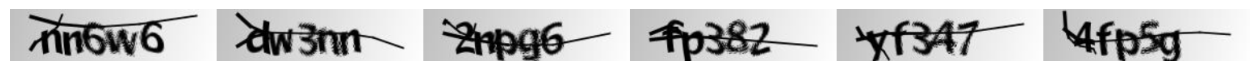

In [10]:
# gettng some random samples from our dataset
# Define the number of samples to display
num_samples = 6
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:num_samples])

## DDPM Architecture
---


The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.
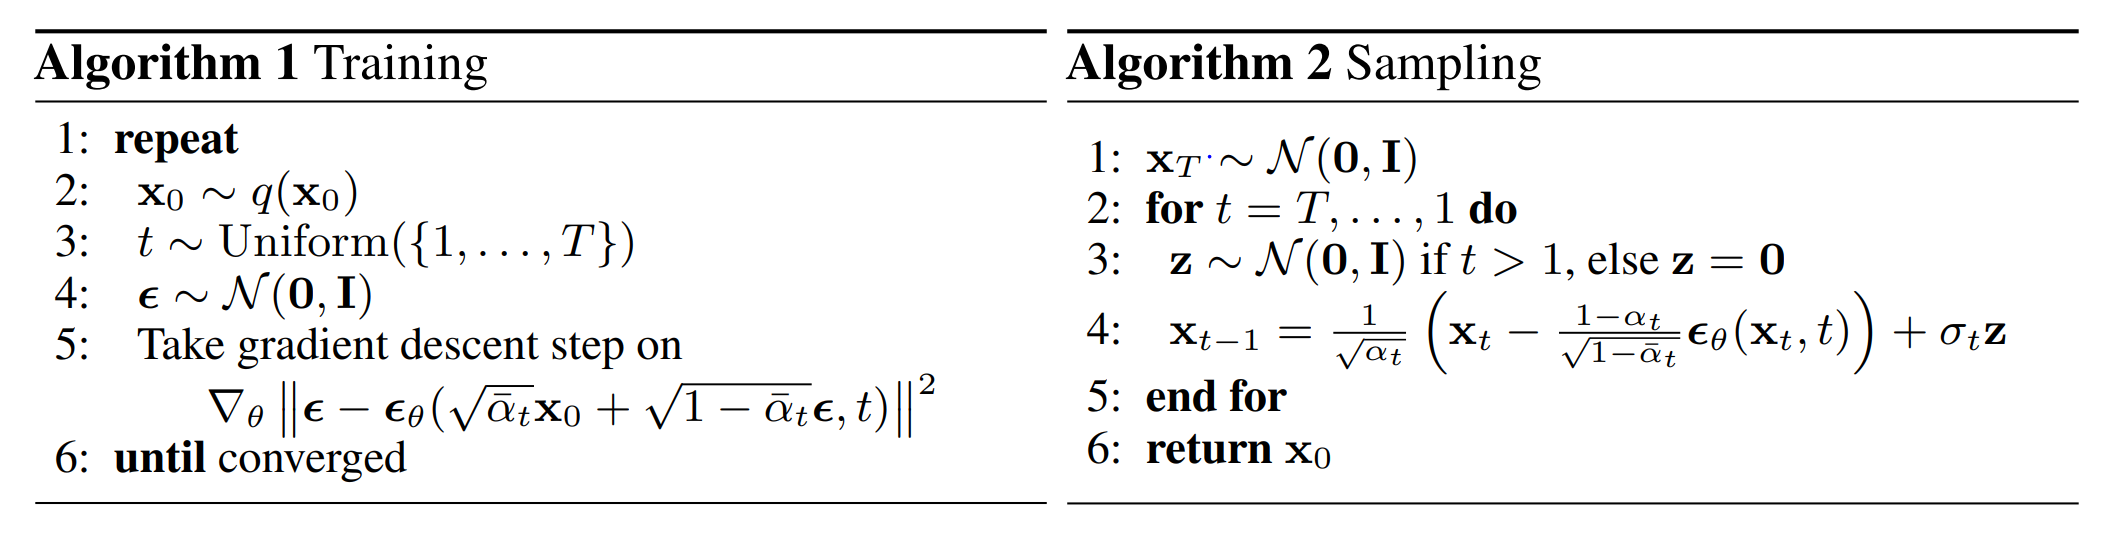

According to the given pseudocode, In the reverse diffusion process, the task is to learn a finite-time (within T timesteps) reversal of the forward diffusion process. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the fully convolutional network architecture proposed by the paper, a U-Net with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules and etc. We describe The UNet network and its architecture in the next section.

The pseudocode also shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. Therefore, we will also use the mentioned loss function to train the network. The pseudo-code provides the formula for generating both noisy and less noisy images, that will be used in the relevant section.


### U-Net

The U-Net architecture, a convolutional neural network framework, has emerged as a powerful tool for semantic segmentation tasks, U-Net is characterized by its unique U-shaped architecture, that allows U-Net to efficiently learn both global and local features, enabling it to achieve best performance in various segmentation challenges.
![unet_ong](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

The figure above illustrates the 2015 U-Net architecture. However, for this homework, we require a customized version with additional sub-modules. In the following cells, we will outline the necessary modules and complete their implementation to construct our final network.

#### Resnet Block

As a base sub-module, we define each Resnet block as two consecutive convolutional layers with a Group Normalization and SiLU activation `before` each convolutional layer. This block will be used other sub-modules (eg:Down/Up blocks):
* GroupNorm
* SiLU
* Conv
* GroupNorm
* SiLU
* Conv

Additionally, there's a linear projection layer that converts the time embedding vector to a vector matching the number of output channels. This projected time embedding is then added to the input after the first convolutional layer. Also, by removing the residual connection, you can use this block as a convolutional network.

Note that if the number of input and output channels for feature maps differs, adding the input to the output for a residual connection may cause issues. In such cases, a 1x1 convolution can be used to ensure input channels match the output dimensions.

Optionally, a dropout layer can added before the second convolution layer. By default, its probability is set to zero, but you can activate it if necessary in your final architecture.

In [11]:
class ResidualBlock(nn.Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step (t) embeddings
        * `n_groups` is the number of groups for [group normalization]
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = nn.SiLU()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

#### Attention Block
This sub-module consisting of :
 * a Group Normalization
 * Multi-head Attention (you can use `torch.nn`)
 * residual conntection
 * a feed-forward layer
 * and another residual connection.

**Note:** In `nn.MultiheadAttention`, there's a `need_weights` parameter that returns attention weights. Set this parameter to false to save GPU memory.

Same as Resnet block, you can add an optional dropout layer after the feed-forward layer. By default, its probability is set to zero, but you can activate it if necessary in your final architecture.

**Bonus:** Implement multihead attention from scratch and utilize it in the attention block.


In [12]:
class AttentionBlock(nn.Module):
    """
    ### Attention block

    This is similar to transformer multi-head attention, but now uses `nn.MultiheadAttention`.
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32, dropout = 0):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for group normalization
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels // n_heads  # Split channels across heads equally

        self.n_heads = n_heads
        self.d_k = d_k
        self.n_channels = n_channels

        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)

        # Multi-head attention layer
        self.mha = nn.MultiheadAttention(embed_dim=n_channels, num_heads=n_heads, batch_first=True)

        # Linear layer for final transformation
        self.ffn = nn.Sequential(
            nn.Linear(n_channels, n_channels * 4),
            nn.ReLU(),
            nn.Linear(n_channels * 4, n_channels),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        """

        # Get shape
        batch_size, n_channels, height, width = x.shape

        # Normalize input
        x = self.norm(x)

        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)

        # Perform multi-head attention (q, k, v are the same input in self-attention)
        attn_output, _ = self.mha(x, x, x)

        # Residual connection
        x = attn_output + x

        res = self.ffn(x) + x

        # Change back to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        return res

#### Down Block

This block is a downsampling block comprised of a series of a ResidualBlock and optionally followed by an AttentionBlock

In [13]:
class DownBlock(nn.Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x

#### Up Block
This block is utilized in the expansive path of the U-Net. Its architecture resembles the DownBlocks, consisting of a ResidualBlock and an AttentionBlock.


In [14]:
class UpBlock(nn.Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


### Sampling
In the U-Net architecture there are up/down sampling blocks. In the first half, down sampling is used to decrease resolution, while increasing the number of channels. In the second half, up sampling blocks are used to increase the resolution back to the original resolution, while decreasing the number of channels.  

For upsampling, we use a convolution transpose layer, and for downsampling, a convolutional layer with stride of 2 is used.

In [15]:
class Upsample(nn.Module):
    """
    Scale up the feature map by 2 times
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    Scale down the feature map by 1/2 times
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

#### Mid Block
In the U-Net architecture, there are bottleneck layers between the contractive and expansive paths. These can be implemented using ResnetBlocks with or without attention layers. Specifically, we define the MidBlock with a ResidualBlock having the same number of input and output channels, followed by an AttentionBlock, followed by a ResidualBlock

In [16]:
class MiddleBlock(nn.Module):
    """
    Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


#### Positional Encoding
In previous sections, we discussed how U-Net predicts noise at each time step. To incorporate the time step into the network, we encode it into an embedding vector and pass it to various layers. Various position encoding methods exist, but we use Sinusoidal position embeddings proposed in the ["Attention is All You Need."](https://arxiv.org/pdf/1706.03762.pdf) paper for this purpose. For more technical details, please refer to the paper.

In [17]:
class TimeEmbedding(nn.Module):
    """
    Sinusoidal positional embeddings for t
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = nn.SiLU()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb

#### Final Network
In this section, we'll construct our U-Net architecture using the blocks defined above. The architecture of the network varies depending on the problem we want to solve. However, for simplicity, we propose a basic architecture suitable for our captcha generation problrm. Feel free to define and test your own architecture for captcha generation.

Proposed Contractive Path Architecture:
- DownBlock(64,64)
- DownBlock(64,64)
- Downsample
- DownBlock(64,128)
- DownBlock(128,128)
- Downsample
- DownBlock(128,256)
- DownBlock(256,256)
- Downsample
- DownBlock(256,1024)
- DownBlock(1024,1024)

Proposed Bottleneck Architecture:
- MidBlock

Proposed Expansive Path Architecture:
- UpBlock(1024,1024)
- UpBlock(1024,1024)
- UpBlock(1024,256)
- Upsample
- UpBlock(256,256)
- UpBlock(256,256)
- UpBlock(256,128)
- Upsample
- UpBlock(128,128)
- UpBlock(128,128)
- UpBlock(128,64)
- Upsample
- UpBlock(64,64)
- UpBlock(64,64)
- UpBlock(64,64)

In [18]:
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, False, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))
        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))

            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = nn.SiLU()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)
        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

## Noise Schuduling (12 points)
Recall that the in diffusion forward process given a data point sampled from a data distribution $ x_0 \sim q(x) $, we want to get a noisy image at step $T$. In particular, the forward diffusion process adds a small amount of Gaussian noise to the sample in $ T $ steps and produces a sequence of noisy samples $ x_1, \ldots, x_T $. The forward diffusion process is controlled by a variance schedule $ \{\beta_t \in (0.0001, 0.02)\}^T_{t=1} $.

$$ q(x_t|x_{t-1}) = N(x_t; \sqrt{1 - \beta_t}x_{t-1}, \beta_t\mathbf{I}) $$

$$ q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1}) $$

The sampled image $ x_0 $ gradually becomes noisier as the step $ t $ becomes larger. Eventually when $ T \rightarrow \infty $, $ x_T $ is equivalent to an isotropic Gaussian distribution. This is a markov process and we can apply the above formulation $T$ times to get to a noisy image at timestep $T$. However, this process is slow and expensive. Fortunately this is not necessary!


Recall that we can sample $x_t$ at any timestep $t$ **directly** using the reparametarization trick.  
Let $\alpha_t = 1-\beta_t$ and $\hat{\alpha}_t = \prod_{i=1}^t \alpha_i$.  
Then  
$ q(x_t|x_0) = N(x_t; \sqrt{\hat{\alpha}_t}x_0, (1 - \hat{\alpha}_t)\mathbf{I})$  

Also in backward process we  can use below algorithm for sampling after training the diffusion model:

1. $ x_T \sim N(0, I) $
2. for $ t = T, \ldots, 1 $ do
3. &emsp;&emsp;$ z \sim N(0, I) $ if $ t > 1 $, else $ z = 0 $
4. &emsp;&emsp;$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{\theta}(x_t, t) \right) + \sigma_t z $
5. end for
6. return $ x_0 $

We will implement the forward and sampling algorithms in the NoiseScheduler class. Based on mentioned information, define the `add_noise` and `denoise` functions as follows:

In [19]:
class NoiseScheduler:
    """
    A class to schedule noise addition during training and perform denoising.

    Args:
        num_train_timesteps (int, optional): Number of training timesteps. Defaults to 1000.
        beta_start (float, optional): Starting value for beta. Defaults to 0.0001.
        beta_end (float, optional): Ending value for beta. Defaults to 0.02.
    """
    def __init__(
        self,
        device,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):

        self.T = num_train_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Linearly spaced betas from beta_start to beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps)

        # Alphas: α_t = 1 - β_t
        self.alphas = 1.0 - self.betas
        self.alphas.to(device)

        # Cumulative product of alphas: \hat{α}_t = ∏_{i=1}^t α_i
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        epsilon: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        """
        Add noise to original samples based on the scheduled betas.

        Args:
            original_samples (torch.FloatTensor): Original samples.
            epsilon (torch.FloatTensor): Noise tensor.
            timesteps (torch.IntTensor): Timesteps.

        Returns:
            torch.FloatTensor: Noisy samples.
        """
        # Get the cumulative product of alphas at the given timesteps
        alpha_t = self.alphas_cumprod[timesteps][:, None, None, None]  # Shape [batch_size, 1, 1, 1]

        # Calculate the noisy samples
        noisy_samples = torch.sqrt(alpha_t) * original_samples + torch.sqrt(1 - alpha_t) * epsilon

        return noisy_samples

    def denoise(
            self,
            noisy_sample: torch.FloatTensor,
            epsilon: torch.FloatTensor,
            timestep: int
        ) -> torch.FloatTensor:
        """
        Denoise a noisy sample at a specific timestep.

        Args:
            noisy_sample (torch.FloatTensor): Noisy sample.
            epsilon (torch.FloatTensor): Noise tensor (predicted noise).
            timestep (int): Timestep.

        Returns:
            torch.FloatTensor: Denoised sample.
        """
        # Get α_t, \hat{α}_t, and β_t at the given timestep
        alpha_t = self.alphas[timestep]
        alpha_cumprod_t = self.alphas_cumprod[timestep]
        beta_t = self.betas[timestep]

        # Sample random noise z from standard normal distribution
        z = torch.randn_like(noisy_sample) if timestep > 0 else 0  # No noise for t=0

        # Calculate the denoised sample using the reverse process equation
        denoised = (1 / torch.sqrt(alpha_t)) * (
            noisy_sample - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * epsilon
        ) + torch.sqrt(beta_t) * z

        return denoised

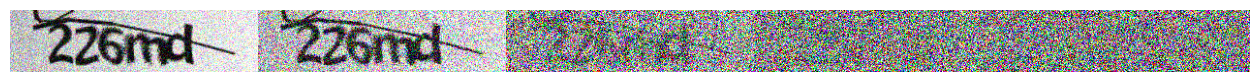

In [20]:
# test our NoiseScheduler
test_scheduler = NoiseScheduler(torch.device('cpu'))
time_steps = torch.tensor([100, 200, 500, 700, 900])
sample = torch.cat([dataset[0][0].unsqueeze(0)] * time_steps.shape[0], dim=0)
noise = torch.randn_like(sample)
noisy_samples = test_scheduler.add_noise(sample, noise , time_steps)
plot_images(noisy_samples)

## Train and Sampling (15 points)
We'll use the DDPM class to train our diffusion model and generate samples. Complete the train and sample methods according to the provided instructions.

In [21]:
class DDPM:
    """
    A class for training and sampling from a Denoising Diffusion Probabilistic Model (DDPM).

    Args:
        sample_size (tuple): Size of the input samples (channels, height, width).
        network (torch.nn.Module): The UNet network for denoising.
        optimizer (torch.optim.Optimizer): Optimizer for training the network.
        criterion (torch.nn.Module): Loss criterion for training.
        noise_shdeduler (NoiseScheduler): Scheduler for adding noise and denoising.
        device (torch.device): Device to perform computations on.
        lr_scheduler (optional): Learning rate scheduler. Defaults to None.
    """
    def __init__(self, sample_size , network, optimizer, criterion, noise_shdeduler: NoiseScheduler, device, lr_scheduler=None):
        self.sample_size = sample_size
        self.network = network.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = noise_shdeduler
        self.device = device
        self.lr_scheduler = lr_scheduler

    def train(self, dataloader, epochs, **kwargs):
        """
        Train the DDPM model.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for training data.
            epochs (int): Number of epochs to train.
            **kwargs: Additional keyword arguments.

        Returns:
            list: History of training losses.
        """

    def train(self, dataloader, epochs, **kwargs):
        history = []
        for epoch in range(epochs):
            total_loss = []
            for i, (batch, _) in enumerate(tqdm(dataloader)):
                # Move batch to the appropriate device (GPU/CPU)
                batch = batch.to(self.device)

                # Sample random time steps t for the batch
                timesteps = torch.randint(0, self.scheduler.T, (batch.size(0),), device=self.device).long()

                # Generate noise for the batch
                noise = torch.randn_like(batch).to(self.device)

                # Create noisy images for the t-th step
                noisy_images = self.scheduler.add_noise(batch, noise, timesteps)

                # Predict the noise using the UNet model
                predicted_noise = self.network(noisy_images, timesteps)

                # Compute the loss (criterion compares the predicted noise with the actual noise)
                loss = self.criterion(predicted_noise, noise)

                # Backpropagate and update the model
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Record the loss
                total_loss.append(loss.item())

            # Calculate the mean loss for the epoch
            mean_loss = np.mean(total_loss)
            lr_str = f"[lr: {self.lr_scheduler.get_last_lr()[0]}]" if self.lr_scheduler else ''
            print(f"[Epoch: {epoch+1}/{epochs}] [loss: {mean_loss:.4f}] {lr_str}")

            # Optionally, update the learning rate scheduler
            if self.lr_scheduler:
                self.lr_scheduler.step()

            # Optionally, generate and display samples every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.sample(5, plot=True)

            # Append the mean loss for history tracking
            history.append(mean_loss)

        return history

    def sample(self, n, plot=True):
        """
        Sample from the trained DDPM model.

        Args:
            n (int): Number of images to sample.
            plot (bool, optional): Whether to plot the sampled images. Defaults to True.
            label (str, optional): Label for the sampled images. Defaults to None.

        Returns:
            torch.Tensor: Sampled image tensor.
        """
        # Step 1: Generate random noise x_T
        x_t = torch.randn((n, *self.sample_size), device=self.device)
        
        # Step 2: Perform denoising for T time steps
        for t in reversed(range(self.scheduler.T)):
            # Predict the noise using the UNet model
            with torch.no_grad(): 
                predicted_noise = self.network(x_t, torch.tensor([t]*n, device=self.device))

            # Denoise the sample
            x_t = self.scheduler.denoise(x_t, predicted_noise, t)
                
        # Step 3: Visualize or return the samples
        if plot:
            plot_images(x_t.clone().detach().cpu().squeeze())
        
        return x_t

To build and train our DDPM, first instantiate a UNet, noise scheduler, optimizer, and loss function. Then, create a DDPM object using them. To begin the training process, call the train method with our dataloader and the required number of epochs. It's recommended to use a learning rate scheduler with warmup steps (e.g., cosine schedule) to facilitate faster model convergence.

In [22]:
# define hyper params
IMG_SIZE = (3, 64, 256)
INITIAL_LR = 3e-4        # Learning rate
EPOCHS = 200             # Number of epochs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
##########################################################
# Create required objects for DDPM
##########################################################
# 1. UNet model for denoising
model = UNet(n_blocks=1)
# model = torch.load('/kaggle/input/ddpm/pytorch/default/1/model.pth')

# 2. NoiseScheduler for handling noise scheduling
scheduler = NoiseScheduler(
    device=DEVICE,
    num_train_timesteps=1000,  # Default is 1000, but you can adjust
    beta_start=0.0001,
    beta_end=0.02
)

# 3. Optimizer
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

# 4. Criterion (loss function) - typically MSE for DDPM
criterion = nn.MSELoss()

In [24]:
ddpm = DDPM(
    sample_size=IMG_SIZE,
    network=model,
    optimizer=optimizer,
    criterion=criterion,
    noise_shdeduler=scheduler,
    device=DEVICE,
    lr_scheduler=None,
) # You can pass your arguments to the call.

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 1/200] [loss: 0.1806] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 2/200] [loss: 0.0588] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 3/200] [loss: 0.0462] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 4/200] [loss: 0.0363] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 5/200] [loss: 0.0323] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 6/200] [loss: 0.0275] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 7/200] [loss: 0.0252] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 8/200] [loss: 0.0285] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 9/200] [loss: 0.0208] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 10/200] [loss: 0.0223] 


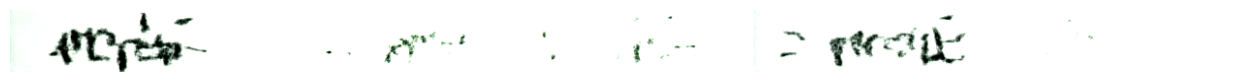

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 11/200] [loss: 0.0228] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 12/200] [loss: 0.0187] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 13/200] [loss: 0.0166] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 14/200] [loss: 0.0173] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 15/200] [loss: 0.0172] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 16/200] [loss: 0.0178] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 17/200] [loss: 0.0147] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 18/200] [loss: 0.0153] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 19/200] [loss: 0.0192] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 20/200] [loss: 0.0160] 


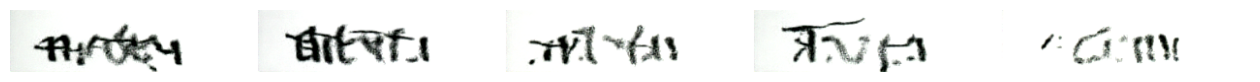

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 21/200] [loss: 0.0139] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 22/200] [loss: 0.0134] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 23/200] [loss: 0.0151] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 24/200] [loss: 0.0129] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 25/200] [loss: 0.0151] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 26/200] [loss: 0.0118] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 27/200] [loss: 0.0123] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 28/200] [loss: 0.0137] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 29/200] [loss: 0.0106] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 30/200] [loss: 0.0098] 


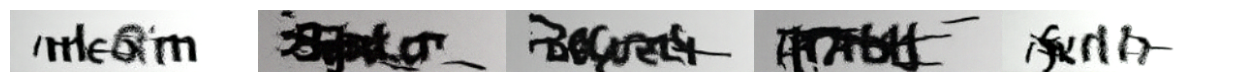

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 31/200] [loss: 0.0107] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 32/200] [loss: 0.0098] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 33/200] [loss: 0.0103] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 34/200] [loss: 0.0111] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 35/200] [loss: 0.0124] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 36/200] [loss: 0.0105] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 37/200] [loss: 0.0117] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 38/200] [loss: 0.0108] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 39/200] [loss: 0.0099] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 40/200] [loss: 0.0099] 


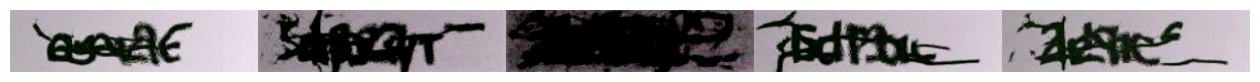

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 41/200] [loss: 0.0096] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 42/200] [loss: 0.0080] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 43/200] [loss: 0.0087] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 44/200] [loss: 0.0102] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 45/200] [loss: 0.0089] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 46/200] [loss: 0.0084] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 47/200] [loss: 0.0081] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 48/200] [loss: 0.0102] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 49/200] [loss: 0.0101] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 50/200] [loss: 0.0105] 


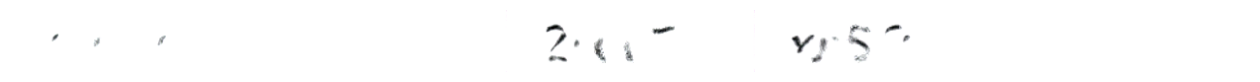

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 51/200] [loss: 0.0094] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 52/200] [loss: 0.0103] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 53/200] [loss: 0.0097] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 54/200] [loss: 0.0079] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 55/200] [loss: 0.0085] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 56/200] [loss: 0.0069] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 57/200] [loss: 0.0101] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 58/200] [loss: 0.0088] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 59/200] [loss: 0.0077] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 60/200] [loss: 0.0111] 


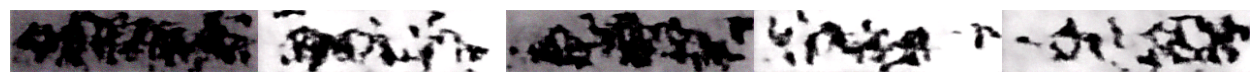

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 61/200] [loss: 0.0201] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 62/200] [loss: 0.0122] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 63/200] [loss: 0.0139] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 64/200] [loss: 0.0115] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 65/200] [loss: 0.0110] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 66/200] [loss: 0.0122] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 67/200] [loss: 0.0099] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 68/200] [loss: 0.0091] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 69/200] [loss: 0.0105] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 70/200] [loss: 0.0126] 


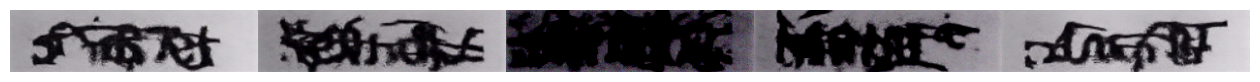

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 71/200] [loss: 0.0113] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 72/200] [loss: 0.0128] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 73/200] [loss: 0.0107] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 74/200] [loss: 0.0091] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 75/200] [loss: 0.0085] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 76/200] [loss: 0.0093] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 77/200] [loss: 0.0099] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 78/200] [loss: 0.0093] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 79/200] [loss: 0.0150] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 80/200] [loss: 0.0096] 


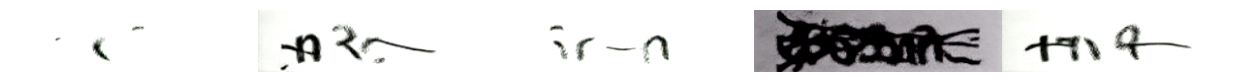

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 81/200] [loss: 0.0097] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 82/200] [loss: 0.0089] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 83/200] [loss: 0.0083] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 84/200] [loss: 0.0072] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 85/200] [loss: 0.0066] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 86/200] [loss: 0.0078] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 87/200] [loss: 0.0082] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 88/200] [loss: 0.0080] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 89/200] [loss: 0.0072] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 90/200] [loss: 0.0076] 


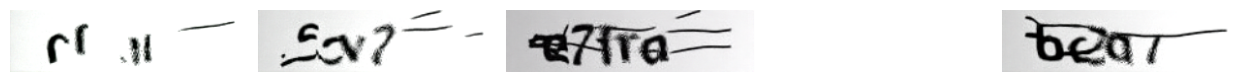

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 91/200] [loss: 0.0082] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 92/200] [loss: 0.0093] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 93/200] [loss: 0.0070] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 94/200] [loss: 0.0085] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 95/200] [loss: 0.0081] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 96/200] [loss: 0.0091] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 97/200] [loss: 0.0076] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 98/200] [loss: 0.0070] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 99/200] [loss: 0.0066] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 100/200] [loss: 0.0078] 


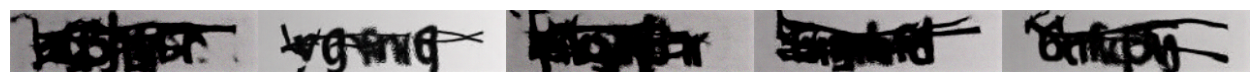

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 101/200] [loss: 0.0068] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 102/200] [loss: 0.0069] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 103/200] [loss: 0.0079] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 104/200] [loss: 0.0078] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 105/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 106/200] [loss: 0.0062] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 107/200] [loss: 0.0096] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 108/200] [loss: 0.0077] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 109/200] [loss: 0.0077] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 110/200] [loss: 0.0073] 


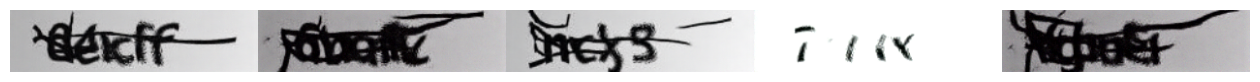

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 111/200] [loss: 0.0056] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 112/200] [loss: 0.0061] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 113/200] [loss: 0.0073] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 114/200] [loss: 0.0071] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 115/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 116/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 117/200] [loss: 0.0059] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 118/200] [loss: 0.0058] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 119/200] [loss: 0.0079] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 120/200] [loss: 0.0064] 


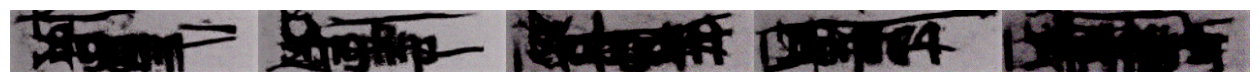

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 121/200] [loss: 0.0077] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 122/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 123/200] [loss: 0.0058] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 124/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 125/200] [loss: 0.0074] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 126/200] [loss: 0.0063] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 127/200] [loss: 0.0071] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 128/200] [loss: 0.0084] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 129/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 130/200] [loss: 0.0073] 


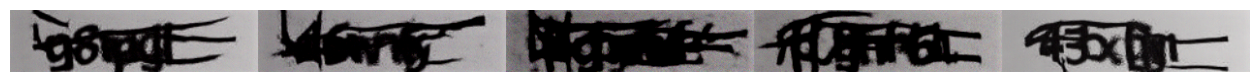

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 131/200] [loss: 0.0066] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 132/200] [loss: 0.0068] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 133/200] [loss: 0.0078] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 134/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 135/200] [loss: 0.0057] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 136/200] [loss: 0.0070] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 137/200] [loss: 0.0061] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 138/200] [loss: 0.0057] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 139/200] [loss: 0.0054] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 140/200] [loss: 0.0058] 


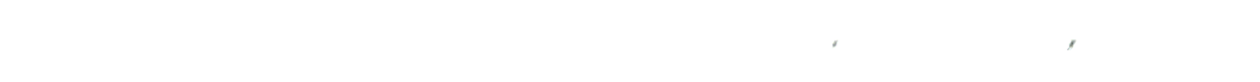

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 141/200] [loss: 0.0057] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 142/200] [loss: 0.0056] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 143/200] [loss: 0.0051] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 144/200] [loss: 0.0055] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 145/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 146/200] [loss: 0.0063] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 147/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 148/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 149/200] [loss: 0.0071] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 150/200] [loss: 0.0056] 


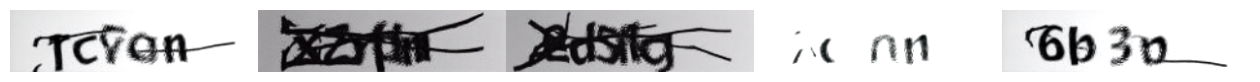

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 151/200] [loss: 0.0062] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 152/200] [loss: 0.0053] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 153/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 154/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 155/200] [loss: 0.0075] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 156/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 157/200] [loss: 0.0063] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 158/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 159/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 160/200] [loss: 0.0057] 


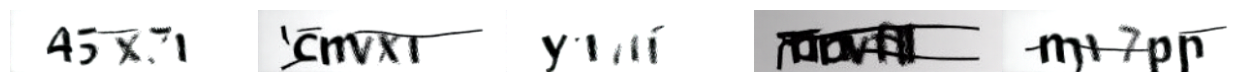

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 161/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 162/200] [loss: 0.0049] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 163/200] [loss: 0.0061] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 164/200] [loss: 0.0053] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 165/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 166/200] [loss: 0.0055] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 167/200] [loss: 0.0050] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 168/200] [loss: 0.0057] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 169/200] [loss: 0.0066] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 170/200] [loss: 0.0060] 


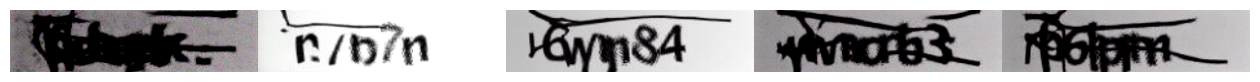

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 171/200] [loss: 0.0059] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 172/200] [loss: 0.0067] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 173/200] [loss: 0.0056] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 174/200] [loss: 0.0054] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 175/200] [loss: 0.0049] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 176/200] [loss: 0.0056] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 177/200] [loss: 0.0059] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 178/200] [loss: 0.0051] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 179/200] [loss: 0.0051] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 180/200] [loss: 0.0124] 


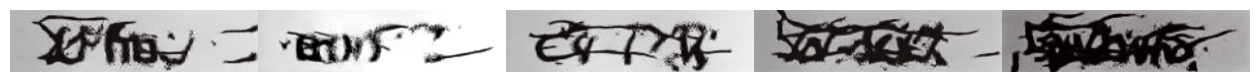

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 181/200] [loss: 0.0090] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 182/200] [loss: 0.0089] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 183/200] [loss: 0.0054] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 184/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 185/200] [loss: 0.0074] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 186/200] [loss: 0.0060] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 187/200] [loss: 0.0065] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 188/200] [loss: 0.0051] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 189/200] [loss: 0.0076] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 190/200] [loss: 0.0053] 


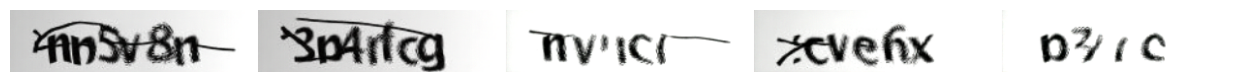

  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 191/200] [loss: 0.0052] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 192/200] [loss: 0.0057] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 193/200] [loss: 0.0052] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 194/200] [loss: 0.0064] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 195/200] [loss: 0.0054] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 196/200] [loss: 0.0053] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 197/200] [loss: 0.0055] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 198/200] [loss: 0.0053] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 199/200] [loss: 0.0059] 


  0%|          | 0/67 [00:00<?, ?it/s]

[Epoch: 200/200] [loss: 0.0061] 


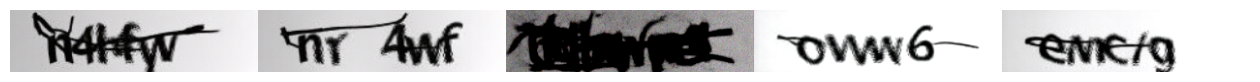

In [25]:
history = ddpm.train(dataloader, EPOCHS)

Generate random samples from the trained model.

Text(0, 0.5, 'Mean Loss')

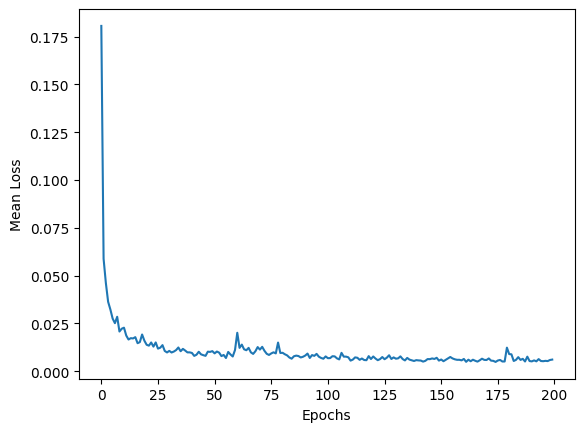

In [26]:
# plot loss history
plt.plot(np.arange(EPOCHS), history)
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')

In [27]:
torch.save(model, 'model.pth')